In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
%matplotlib inline

In [7]:
def classify_protein(protein):
    result = 'UNKNOWN'
    if 'HUMAN' in protein.upper():
        result = 'HUMAN'
    elif 'YEAST' in protein.upper():
        result = 'YEAST'
    elif 'ECOLI' in protein.upper():
        result = 'E.COLI'
    return result

In [20]:
EXPERIMENT_NAME = 'P3856'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(EXPERIMENT_NAME)

In [9]:
# load the results
RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [10]:
# convert the identifications from JSON to Python objects
results_df['identifications_d'] = results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [11]:
# separate some key metrics into separate columns
results_df['id_perc_q_value'] = results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
results_df['id_count_all_runs'] = results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
results_df['id_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s for s in row.identifications_d['run_names']), axis=1)
results_df['id_number_of_proteins'] = results_df.apply(lambda row: row.identifications_d['number_of_proteins'], axis=1)

In [12]:
results_df['id_protein'] = results_df.apply(lambda row: row.identifications_d['proteins'][0], axis=1)
results_df['id_species'] = results_df.apply(lambda row: classify_protein(row.id_protein), axis=1)

In [13]:
# count the number of unique peptide identifications in each run
counts_d = {}
for row in results_df.itertuples():
    for run_name in row.identifications_d['run_names']:
        if run_name not in counts_d:
            counts_d[run_name] = 0
        counts_d[run_name] += 1

In [16]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, counts_d[k]))
sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])
sorted_counts_df.index = sorted_counts_df.run_name

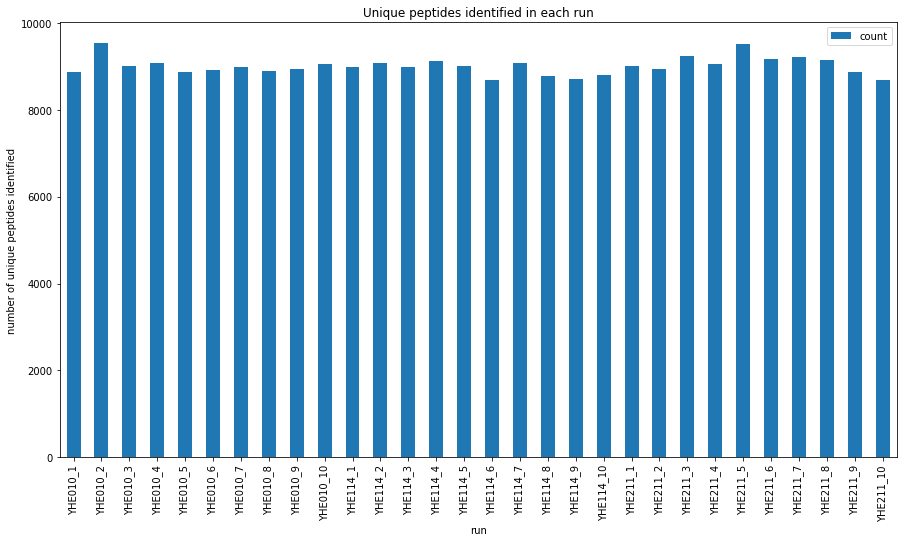

In [18]:
sorted_counts_df.plot(kind='bar', figsize=(15,8))
_ = plt.title("Unique peptides identified in each run")
_ = plt.xlabel("run")
_ = plt.ylabel("number of unique peptides identified")

In [30]:
sequence_library_df = pd.read_pickle('{}/sequence-library/sequence-library.pkl'.format(EXPERIMENT_DIR))

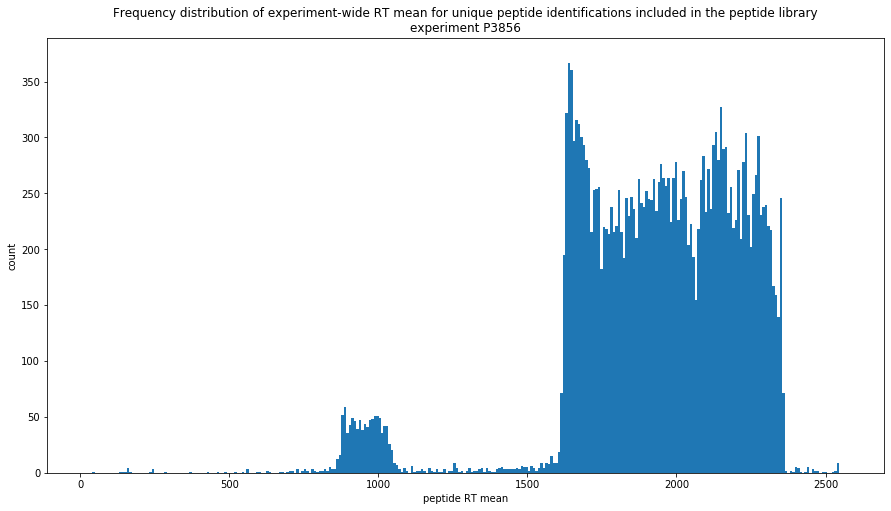

In [31]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_library_df.experiment_rt_mean
y, x, _ = ax1.hist(values, bins=bins)

plt.xlabel('peptide RT mean')
plt.ylabel('count')
plt.title('Frequency distribution of experiment-wide RT mean for unique peptide identifications included in the peptide library\nexperiment {}'.format(EXPERIMENT_NAME))
# plt.xlim((0,2))
# plt.ylim((0,1000))

plt.show()

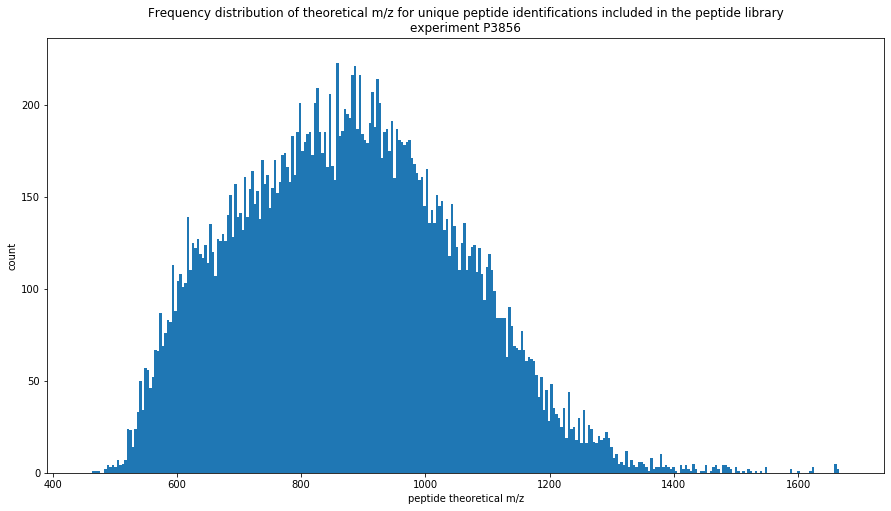

In [47]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_library_df.theoretical_mz
y, x, _ = ax1.hist(values, bins=bins)

plt.xlabel('peptide theoretical m/z')
plt.ylabel('count')
plt.title('Frequency distribution of theoretical m/z for unique peptide identifications included in the peptide library\nexperiment {}'.format(EXPERIMENT_NAME))
# plt.xlim((0,2))
# plt.ylim((0,1000))

plt.show()

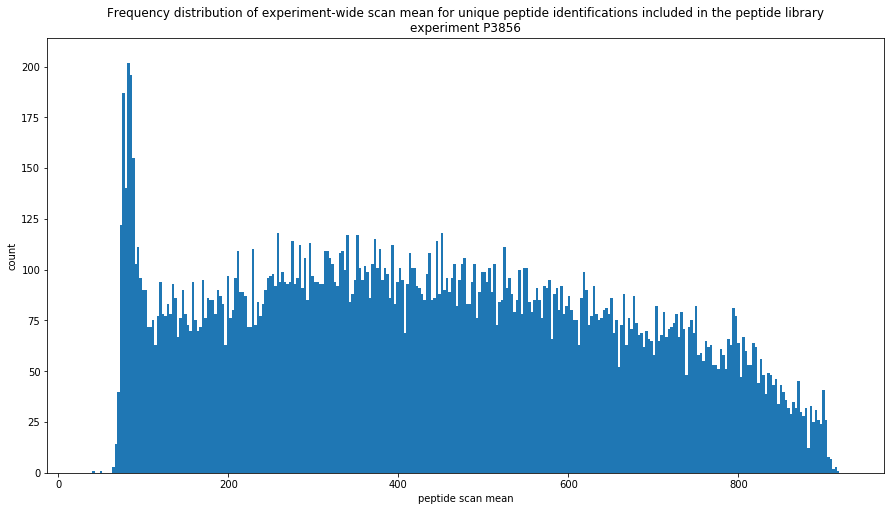

In [48]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_library_df.experiment_scan_mean
y, x, _ = ax1.hist(values, bins=bins)

plt.xlabel('peptide scan mean')
plt.ylabel('count')
plt.title('Frequency distribution of experiment-wide scan mean for unique peptide identifications included in the peptide library\nexperiment {}'.format(EXPERIMENT_NAME))
# plt.xlim((0,2))
# plt.ylim((0,1000))

plt.show()

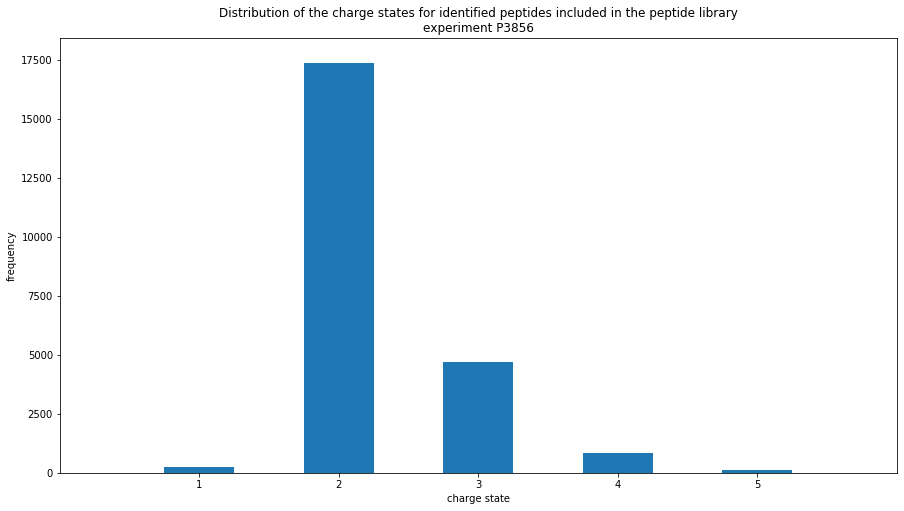

In [46]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Distribution of the charge states for identified peptides included in the peptide library\nexperiment {}'.format(EXPERIMENT_NAME))

NUMBER_OF_CHARGE_STATES = sequence_library_df.charge.max()
counts = np.bincount(sequence_library_df.charge)

ax1.bar(range(NUMBER_OF_CHARGE_STATES+1), counts, width=0.5, align='center')

plt.xlabel('charge state')
plt.ylabel('frequency')
ax1.set(xticks=range(1,NUMBER_OF_CHARGE_STATES+1), xlim=[0, NUMBER_OF_CHARGE_STATES+1])

plt.show()

#### compare estimated and extraction coordinates

In [ ]:
EXTRACTED_FEATURES_DB_NAME = '{}/extracted-features/extracted-features.sqlite'.format(EXPERIMENT_DIR)
print('loading the extractions from {}'.format(EXTRACTED_FEATURES_DB_NAME))
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
extracted_features_df = pd.read_sql_query("select sequence,charge,run_name,prob_target,intensity,inferred from features where classed_as == \'target\'", db_conn)
db_conn.close()